In [1]:
import collections
# Prepare paths to local utilities
import os
import sys

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_squared_error

In [2]:
is_kaggle = (os.environ.get("PWD", "") == "/kaggle/working")
print(f"Are we running in Kaggle? {is_kaggle}")

Are we running in Kaggle? False


In [3]:
if not is_kaggle:
    models_path = os.path.abspath(os.path.join('..', 'model'))
    utils_path = os.path.abspath(os.path.join('..', 'util'))
    sys.path.append(models_path)
    sys.path.append(utils_path)

    %load_ext autoreload
    %autoreload 2

    from download.DataDownloader import DataDownloader
    from collect.DataframeCollector import DataframeCollector
    from collect.TestSetSplitter import TestSetSplitter
    from collect.DatasetPreparation import DatasetPreparation
    from processing.DataPreprocessor import DataPreprocessor
    from reservoir.BasicESNCuda import BasicESNCuda as BasicESN
    from reservoir.HierarchyESNCuda import HierarchyESNCuda as HierarchyESN
    from reservoir.ThreeHierarchyESNCuda import ThreeHierarchyESNCuda as ThreeHierarchyESN
    from reservoir.ESNUtil import generate_input_weights

else:
    from datadownloader.datadownloader import DataDownloader
    from dataframecollector.dataframecollector import DataframeCollector
    from testsetsplitter.testsetsplitter import TestSetSplitter
    from datasetpreparation.datasetpreparation import DatasetPreparation
    from datapreprocessor.datapreprocessor import DataPreprocessor
    from basicesncuda.basicesncuda import BasicESNCuda as BasicESN
    from esnutil.esnutil import generate_input_weights

In [4]:
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
import contextlib


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    '''
    Context manager to patch joblib to report into tqdm progress bar given as argument
    :param tqdm_object: The tqdm progress bar
    '''

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback

    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [5]:
data_preparation = DatasetPreparation()

input_features = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
output_features = ['label']

data_preparation.prepare_dataset('har70plus', input_features, output_features)

X_train, y_train = data_preparation.get_raw_data('train')
X_val, y_val = data_preparation.get_raw_data('val')
X_test, y_test = data_preparation.get_raw_data('test')

X_train_scaled, y_train_encoded = data_preparation.get_preprocessed_data('train')
X_val_scaled, y_val_encoded = data_preparation.get_preprocessed_data('val')
X_test_scaled, y_test_encoded = data_preparation.get_preprocessed_data('test')

class_weights = data_preparation.get_class_weights()

data_preprocessor = DataPreprocessor()

Dataset already downloaded
Discovered  18  csv files in  E:\PyCharm\COM6906-Dissertation\data\har70plus
Loading the csv files into dataframes
Loaded  18  dataframes
Concatenating the dataframes
Data shape:  [(103860, 9), (131367, 9), (116413, 9), (150758, 9), (87006, 9), (122714, 9), (120125, 9), (130494, 9), (121763, 9), (122061, 9), (128063, 9), (119310, 9), (123599, 9), (101510, 9), (153517, 9), (138278, 9), (147045, 9), (141714, 9)]
Number of frames in training set: 17
Number of frames in validation set: 17
Number of frames in testing set: 18
X_train shape: (1357646, 6), Y_train shape: (1357646,)
X_val shape: (339404, 6), Y_val shape: (339404,)
X_test shape: (562547, 6), Y_test shape: (562547,)
Y_train encoded shape: (1357646, 7)
Y_val encoded shape: (339404, 7)
Y_test encoded shape: (562547, 7)
Y_train decoded shape: (1357646, 1)
Y_val decoded shape: (339404, 1)
Y_test decoded shape: (562547, 1)
X_train scaled shape: (1357646, 6)
X_val scaled shape: (339404, 6)
X_test scaled shape

In [6]:
# The data preprocessor object provides access to different data preprocessing methods
# The available methods are:
# - buffered_windows(window_size, x, y)
# - exponential_moving_average(alpha, x, y)
# - fourier_smoothing(x, threshold)
# - spectrogram_data(x, y, n_fft, stride, reshape)
# - spectrogram_predictions_to_samples(y_pred, n_samples, n_fft, stride)
# - pipeline(step_names, x, y)
# - get_available_steps()

# First, we will try a basicESN with the optimal hyperparameters found in the previous notebook along with the spectrogram_data preprocessing method

# The optimal hyperparameters were:
basic_n_neurons = 500
basic_density = 0.2
basic_leakage = 0.8
basic_spectral_radius = 0.999
basic_gamma = 0.999
basic_sparsity = 0.8
basic_input_weight_type = 'uniform'


In [7]:
run_basic_optimal = True

In [10]:


if run_basic_optimal:
    n_ffts = [32, 64, 128]
    strides = [16, 32, 64, 128]

    basic_optimal_scores = []

    for n_fft in n_ffts:
        for stride in strides:
            if stride > n_fft:
                continue

            x_train_spec, y_train_spec = data_preprocessor.spectrogram_data(X_train, y_train,
                                                                            n_fft=n_fft, stride=stride,
                                                                            encode_labels=True,
                                                                            label_encoder=data_preparation.get_encoder())
            x_val_spec, y_val_spec = data_preprocessor.spectrogram_data(X_val, y_val, n_fft=n_fft,
                                                                        stride=stride,
                                                                        encode_labels=True,
                                                                        label_encoder=data_preparation.get_encoder())
            x_test_spec, y_test_spec = data_preprocessor.spectrogram_data(X_test, y_test, n_fft=n_fft,
                                                                          stride=stride,
                                                                          encode_labels=True,
                                                                          label_encoder=data_preparation.get_encoder())

            # Generate input weights has parameters n_neurons, n_features, density, input_weight_type
            input_weights = generate_input_weights(basic_n_neurons, x_train_spec.shape[1], basic_density,
                                                   basic_input_weight_type, seed=42)

            basic_esn = BasicESN(n_neurons=basic_n_neurons, leakage_rate=basic_leakage,
                                 spectral_radius=basic_spectral_radius,
                                 gamma=basic_gamma,
                                 sparsity=basic_sparsity, W_in=input_weights, class_weights=class_weights, seed=42)

            basic_esn.fit(x_train_spec, y_train_spec, x_val=x_val_spec, y_val=y_val_spec)

            y_pred = basic_esn.forward(x_test_spec)

            # Before we can score the model, we need to decode the one-hot encoded labels
            # As we are using the spectrogram_data method, we need to convert the time frames back to samples
            y_pred_samples = data_preprocessor.spectrogram_predictions_to_samples(y_pred, y_test_encoded.shape[0],
                                                                                  n_fft, stride)

            y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred_samples)
            y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_encoded)

            # Calculate the NMRSE score
            nrmse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (
                    y_test_decoded.max() - y_test_decoded.min())

            basic_optimal_scores.append({'n_fft': n_fft, 'stride': stride, 'nmrse': nrmse})

            print(f"n_fft: {n_fft}, stride: {stride}, NMRSE: {nrmse}")

else:
    basic_optimal_scores = []

Spectrogram data shape: (84853, 102), (84853, 7)
Spectrogram data shape: (21213, 102), (21213, 7)
Spectrogram data shape: (35160, 102), (35160, 7)
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.8, spectral_radius: 0.999, gamma: 0.999, n_neurons: 500, sparsity: 0.8


100%|██████████| 84853/84853 [00:24<00:00, 3441.08it/s]


Shape of previous_states: (84853, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, scoring readout layer based on validation data...


100%|██████████| 21213/21213 [00:05<00:00, 3576.22it/s]


Shape of previous_states: (21213, 500)
Alpha: 1e-05, Score: 0.29211041179134056
Alpha: 5.994842503189409e-05, Score: 0.30356072333379724


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.01321e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.00035938136638046257, Score: 0.30397176105650175


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.05598e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.0021544346900318843, Score: 0.3041269188382433


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.52783e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.01291549665014884, Score: 0.30453971847209677


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.26193e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.0774263682681127, Score: 0.3052610598745736


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.12645e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.4641588833612782, Score: 0.30667371566463186


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.61507e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.782559402207126, Score: 0.30913267980945197
Alpha: 16.68100537200059, Score: 0.3131172323766384
Alpha: 100.0, Score: 0.31809304511054975
Best alpha: 100.0
Readout layer fitted.


100%|██████████| 35160/35160 [00:09<00:00, 3558.17it/s]


Shape of previous_states: (35160, 500)
Cumulative samples shape: (562547, 7)
n_fft: 32, stride: 16, NMRSE: 0.2280657272340775
Spectrogram data shape: (42427, 102), (42427, 7)
Spectrogram data shape: (10607, 102), (10607, 7)
Spectrogram data shape: (17580, 102), (17580, 7)
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.8, spectral_radius: 0.999, gamma: 0.999, n_neurons: 500, sparsity: 0.8


100%|██████████| 42427/42427 [00:11<00:00, 3561.92it/s]


Shape of previous_states: (42427, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, scoring readout layer based on validation data...


100%|██████████| 10607/10607 [00:03<00:00, 3469.03it/s]


Shape of previous_states: (10607, 500)
Alpha: 1e-05, Score: 0.2510989416719584
Alpha: 5.994842503189409e-05, Score: 0.2678344583490647
Alpha: 0.00035938136638046257, Score: 0.2684259034419193
Alpha: 0.0021544346900318843, Score: 0.26820060378009675


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.8856e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.04551e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.01291549665014884, Score: 0.27194403118726923
Alpha: 0.0774263682681127, Score: 0.2752524496314778


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.14616e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.02183e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.4641588833612782, Score: 0.27943732661740733
Alpha: 2.782559402207126, Score: 0.28479895009173
Alpha: 16.68100537200059, Score: 0.2915919973006454
Alpha: 100.0, Score: 0.2992104288864229
Best alpha: 100.0
Readout layer fitted.


100%|██████████| 17580/17580 [00:05<00:00, 3487.99it/s]


Shape of previous_states: (17580, 500)
Cumulative samples shape: (562547, 7)
n_fft: 32, stride: 32, NMRSE: 0.2582511147320702
Spectrogram data shape: (84853, 198), (84853, 7)
Spectrogram data shape: (21213, 198), (21213, 7)
Spectrogram data shape: (35160, 198), (35160, 7)
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.8, spectral_radius: 0.999, gamma: 0.999, n_neurons: 500, sparsity: 0.8


100%|██████████| 84853/84853 [00:23<00:00, 3592.51it/s]


Shape of previous_states: (84853, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, scoring readout layer based on validation data...


100%|██████████| 21213/21213 [00:05<00:00, 3567.17it/s]


Shape of previous_states: (21213, 500)
Alpha: 1e-05, Score: -0.05737330208626671
Alpha: 5.994842503189409e-05, Score: 0.24992379691709946
Alpha: 0.00035938136638046257, Score: 0.3003447031499477
Alpha: 0.0021544346900318843, Score: 0.3023153887137684
Alpha: 0.01291549665014884, Score: 0.30233630079039375


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.50577e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.0774263682681127, Score: 0.30207843144983304


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.03082e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.4641588833612782, Score: 0.3023208496016266


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.69706e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.782559402207126, Score: 0.30216384083155706
Alpha: 16.68100537200059, Score: 0.3024205747962035
Alpha: 100.0, Score: 0.30306107282062317
Best alpha: 100.0
Readout layer fitted.


100%|██████████| 35160/35160 [00:09<00:00, 3565.71it/s]


Shape of previous_states: (35160, 500)
Cumulative samples shape: (562547, 7)
n_fft: 64, stride: 16, NMRSE: 0.27527477016579643
Spectrogram data shape: (42427, 198), (42427, 7)
Spectrogram data shape: (10607, 198), (10607, 7)
Spectrogram data shape: (17580, 198), (17580, 7)
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.8, spectral_radius: 0.999, gamma: 0.999, n_neurons: 500, sparsity: 0.8


100%|██████████| 42427/42427 [00:11<00:00, 3600.06it/s]


Shape of previous_states: (42427, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, scoring readout layer based on validation data...


100%|██████████| 10607/10607 [00:03<00:00, 3505.72it/s]


Shape of previous_states: (10607, 500)
Alpha: 1e-05, Score: 0.28183024911890414
Alpha: 5.994842503189409e-05, Score: 0.28201459491634034
Alpha: 0.00035938136638046257, Score: 0.2821478135469521
Alpha: 0.0021544346900318843, Score: 0.28223855013854643
Alpha: 0.01291549665014884, Score: 0.28242914845724304
Alpha: 0.0774263682681127, Score: 0.2822406067301872


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.97083e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.19264e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.4641588833612782, Score: 0.28335737457748617
Alpha: 2.782559402207126, Score: 0.28459774547726907
Alpha: 16.68100537200059, Score: 0.28615671737652454
Alpha: 100.0, Score: 0.28905155807699273
Best alpha: 100.0
Readout layer fitted.


100%|██████████| 17580/17580 [00:05<00:00, 3489.77it/s]


Shape of previous_states: (17580, 500)
Cumulative samples shape: (562547, 7)
n_fft: 64, stride: 32, NMRSE: 0.28840790202385225
Spectrogram data shape: (21214, 198), (21214, 7)
Spectrogram data shape: (5304, 198), (5304, 7)
Spectrogram data shape: (8790, 198), (8790, 7)
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.8, spectral_radius: 0.999, gamma: 0.999, n_neurons: 500, sparsity: 0.8


100%|██████████| 21214/21214 [00:06<00:00, 3528.22it/s]


Shape of previous_states: (21214, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, scoring readout layer based on validation data...


100%|██████████| 5304/5304 [00:01<00:00, 3276.77it/s]


Shape of previous_states: (5304, 500)
Alpha: 1e-05, Score: 0.20409740718190794
Alpha: 5.994842503189409e-05, Score: 0.24861642726836278
Alpha: 0.00035938136638046257, Score: 0.2495852881509637
Alpha: 0.0021544346900318843, Score: 0.25004996195125406
Alpha: 0.01291549665014884, Score: 0.25274167216913784
Alpha: 0.0774263682681127, Score: 0.255208936960832
Alpha: 0.4641588833612782, Score: 0.26013620580189895


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.62471e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.36172e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.76359e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.782559402207126, Score: 0.2632387650962288
Alpha: 16.68100537200059, Score: 0.2672034958679075
Alpha: 100.0, Score: 0.2719994186803034
Best alpha: 100.0
Readout layer fitted.


100%|██████████| 8790/8790 [00:02<00:00, 3407.87it/s]


Shape of previous_states: (8790, 500)
Cumulative samples shape: (562547, 7)
n_fft: 64, stride: 64, NMRSE: 0.2921680882260777
Spectrogram data shape: (84853, 390), (84853, 7)
Spectrogram data shape: (21213, 390), (21213, 7)
Spectrogram data shape: (35160, 390), (35160, 7)
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.8, spectral_radius: 0.999, gamma: 0.999, n_neurons: 500, sparsity: 0.8


100%|██████████| 84853/84853 [00:24<00:00, 3498.73it/s]


Shape of previous_states: (84853, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, scoring readout layer based on validation data...


100%|██████████| 21213/21213 [00:06<00:00, 3532.72it/s]


Shape of previous_states: (21213, 500)
Alpha: 1e-05, Score: 0.2530362439698336
Alpha: 5.994842503189409e-05, Score: 0.25303804782430867
Alpha: 0.00035938136638046257, Score: 0.253041377602369
Alpha: 0.0021544346900318843, Score: 0.25305946533750806


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.25086e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.01291549665014884, Score: 0.25218350522884136


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.73468e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.0774263682681127, Score: 0.2528341714561189


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.06211e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.4641588833612782, Score: 0.25369120343218476
Alpha: 2.782559402207126, Score: 0.25466966554413945
Alpha: 16.68100537200059, Score: 0.25585767137704635
Alpha: 100.0, Score: 0.2577360157857726
Best alpha: 100.0
Readout layer fitted.


100%|██████████| 35160/35160 [00:10<00:00, 3474.63it/s]


Shape of previous_states: (35160, 500)
Cumulative samples shape: (562547, 7)
n_fft: 128, stride: 16, NMRSE: 0.31600511056423325
Spectrogram data shape: (42427, 390), (42427, 7)
Spectrogram data shape: (10607, 390), (10607, 7)
Spectrogram data shape: (17580, 390), (17580, 7)
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.8, spectral_radius: 0.999, gamma: 0.999, n_neurons: 500, sparsity: 0.8


100%|██████████| 42427/42427 [00:12<00:00, 3487.64it/s]


Shape of previous_states: (42427, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, scoring readout layer based on validation data...


100%|██████████| 10607/10607 [00:03<00:00, 3437.75it/s]


Shape of previous_states: (10607, 500)
Alpha: 1e-05, Score: 0.22847272761879553
Alpha: 5.994842503189409e-05, Score: 0.22847811973216733
Alpha: 0.00035938136638046257, Score: 0.22850958839735233
Alpha: 0.0021544346900318843, Score: 0.22867581462455858
Alpha: 0.01291549665014884, Score: 0.22930136282942776
Alpha: 0.0774263682681127, Score: 0.23202091374928438


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.46755e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.49762e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.4641588833612782, Score: 0.23431767984051935
Alpha: 2.782559402207126, Score: 0.23668116002263168
Alpha: 16.68100537200059, Score: 0.2398346756878215
Alpha: 100.0, Score: 0.2439901981605054
Best alpha: 100.0
Readout layer fitted.


100%|██████████| 17580/17580 [00:05<00:00, 3313.20it/s]


Shape of previous_states: (17580, 500)
Cumulative samples shape: (562547, 7)
n_fft: 128, stride: 32, NMRSE: 0.3217979825871944
Spectrogram data shape: (21214, 390), (21214, 7)
Spectrogram data shape: (5304, 390), (5304, 7)
Spectrogram data shape: (8790, 390), (8790, 7)
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.8, spectral_radius: 0.999, gamma: 0.999, n_neurons: 500, sparsity: 0.8


100%|██████████| 21214/21214 [00:06<00:00, 3457.21it/s]


Shape of previous_states: (21214, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, scoring readout layer based on validation data...


100%|██████████| 5304/5304 [00:01<00:00, 3160.13it/s]


Shape of previous_states: (5304, 500)
Alpha: 1e-05, Score: 0.19424343390526685
Alpha: 5.994842503189409e-05, Score: 0.19431041618939363
Alpha: 0.00035938136638046257, Score: 0.1947006759934662
Alpha: 0.0021544346900318843, Score: 0.19653735410462497
Alpha: 0.01291549665014884, Score: 0.20132374617318585
Alpha: 0.0774263682681127, Score: 0.20305465327014013


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.56835e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.18146e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.23156e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.4641588833612782, Score: 0.2065905335154774
Alpha: 2.782559402207126, Score: 0.21111097887500363
Alpha: 16.68100537200059, Score: 0.21878559034569184
Alpha: 100.0, Score: 0.22902386257172092
Best alpha: 100.0
Readout layer fitted.


100%|██████████| 8790/8790 [00:02<00:00, 3386.95it/s]


Shape of previous_states: (8790, 500)
Cumulative samples shape: (562547, 7)
n_fft: 128, stride: 64, NMRSE: 0.3014533935065895
Spectrogram data shape: (10607, 390), (10607, 7)
Spectrogram data shape: (2652, 390), (2652, 7)
Spectrogram data shape: (4395, 390), (4395, 7)
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.8, spectral_radius: 0.999, gamma: 0.999, n_neurons: 500, sparsity: 0.8


100%|██████████| 10607/10607 [00:03<00:00, 3414.28it/s]


Shape of previous_states: (10607, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, scoring readout layer based on validation data...


100%|██████████| 2652/2652 [00:00<00:00, 3051.02it/s]


Shape of previous_states: (2652, 500)
Alpha: 1e-05, Score: 0.10673233011184302
Alpha: 5.994842503189409e-05, Score: 0.10704970548001484
Alpha: 0.00035938136638046257, Score: 0.11674661503839455
Alpha: 0.0021544346900318843, Score: 0.13497775710995594
Alpha: 0.01291549665014884, Score: 0.1390858628924964
Alpha: 0.0774263682681127, Score: 0.14667493531288991
Alpha: 0.4641588833612782, Score: 0.1472290766811098
Alpha: 2.782559402207126, Score: 0.15440545086997354
Alpha: 16.68100537200059, Score: 0.17415962850808375


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.22144e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.04395e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 100.0, Score: 0.1982254919484449
Best alpha: 100.0
Readout layer fitted.


100%|██████████| 4395/4395 [00:01<00:00, 3144.08it/s]


Shape of previous_states: (4395, 500)
Cumulative samples shape: (562547, 7)
n_fft: 128, stride: 128, NMRSE: 0.3128999475893049


In [11]:
print(basic_optimal_scores)

[{'n_fft': 32, 'stride': 16, 'nmrse': 0.2280657272340775}, {'n_fft': 32, 'stride': 32, 'nmrse': 0.2582511147320702}, {'n_fft': 64, 'stride': 16, 'nmrse': 0.27527477016579643}, {'n_fft': 64, 'stride': 32, 'nmrse': 0.28840790202385225}, {'n_fft': 64, 'stride': 64, 'nmrse': 0.2921680882260777}, {'n_fft': 128, 'stride': 16, 'nmrse': 0.31600511056423325}, {'n_fft': 128, 'stride': 32, 'nmrse': 0.3217979825871944}, {'n_fft': 128, 'stride': 64, 'nmrse': 0.3014533935065895}, {'n_fft': 128, 'stride': 128, 'nmrse': 0.3128999475893049}]


In [12]:
# Let's plot the results to see if there is a clear winner
# Get the best n_fft and stride values
def reshape_nfft_scores(scores_list):
    reshaped_list = []
    current_nfft = scores_list[0]['n_fft']
    current_list_scores = []
    current_list_strides = []
    for i in range(len(scores_list)):
        if scores_list[i]['n_fft'] != current_nfft:
            reshaped_list.append({
                'n_fft': current_nfft,
                'nmrses': current_list_scores,
                'strides': current_list_strides
            })
            current_list_scores = []
            current_list_strides = []
            current_nfft = scores_list[i]['n_fft']

        current_list_scores.append(scores_list[i]['nmrse'])
        current_list_strides.append(scores_list[i]['stride'])
    reshaped_list.append({
        'n_fft': current_nfft,
        'nmrses': current_list_scores,
        'strides': current_list_strides
    })

    return reshaped_list

In [37]:
def get_best_and_plot(reshaped_scores):
    best_nfft = reshaped_scores[np.argmin([min(result['nmrses']) for result in reshaped_scores])]['n_fft']
    best_stride = reshaped_scores[np.argmin([min(result['nmrses']) for result in reshaped_scores])]['strides'][
        np.argmin(reshaped_scores[np.argmin([min(result['nmrses']) for result in reshaped_scores])]['nmrses'])]

    print(f"Best n_fft: {best_nfft}, Best stride: {best_nfft}")  #%%

    plt.figure(figsize=(10, 5))

    for result in reshaped_scores:
        plt.plot(result['strides'], result['nmrses'], marker='o', label=f"n_fft: {result['n_fft']}")

    plt.xlabel('Stride')
    plt.ylabel('Test score')
    plt.title('Test score for each n_fft and stride value (anything outside the score range [-5, 1] is omitted)')
    plt.xscale('log')
    # Some of the values have terrible scores, and so can be omitted from the plot
    #plt.ylim(-5, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return best_nfft, best_stride

Best n_fft: 32, Best stride: 32


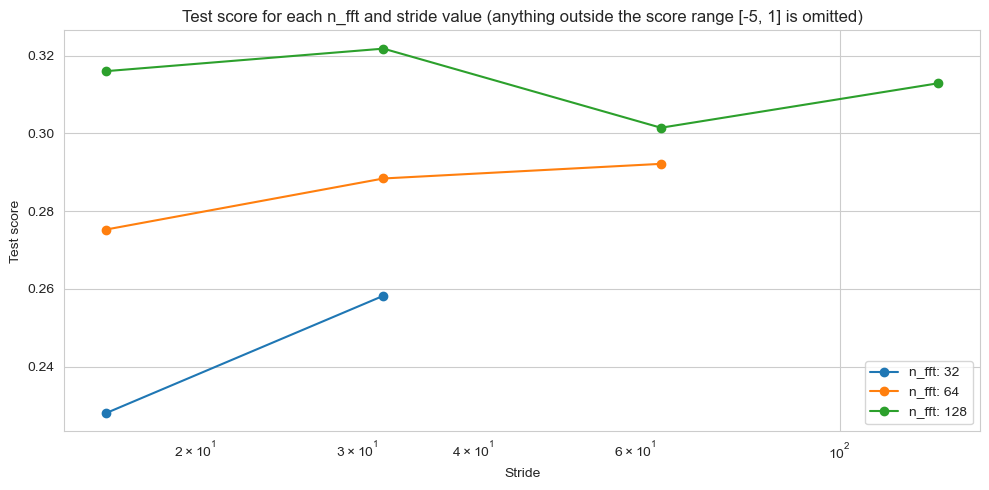

In [38]:
basic_optimal_results_list_reshaped = reshape_nfft_scores(basic_optimal_scores)
best_nfft_basic, best_stride_basic = get_best_and_plot(basic_optimal_results_list_reshaped)

In [15]:
# Next, we will try with the HierarchicalESN with the optimal hyperparameters found in the previous notebook along with the spectrogram_data preprocessing method

# The optimal hyperparameters were:
# Best Neurons 1: 400, Best Neurons 2: 100
# Best Density 1: 0.7983216917715843, Best Density 2: 0.010877135881297934
# Best Leakage Rate 1: 0.9318915931720418, Best Leakage Rate 2: 0.35101073644620073
# Best Spectral Radius 1: 0.9819903553570943, Best Spectral Radius 2: 0.1404437385565157
# Best Gamma 1: 0.9634809164294149, Best Gamma 2: 0.7797466776214464
# Best Weight Distribution 1: uniform, Best Weight Distribution 2: 0/1
# Best Sparsity 1: 0.8, Best Sparsity 2: 0.5
hierarchy_n_neurons_1 = 400
hierarchy_density_1 = 0.7983216917715843
hierarchy_leakage_1 = 0.9318915931720418
hierarchy_spectral_radius_1 = 0.9819903553570943
hierarchy_gamma_1 = 0.9634809164294149
hierarchy_sparsity_1 = 0.8
hierarchy_input_weight_type_1 = 'uniform'

hierarchy_n_neurons_2 = 100
hierarchy_density_2 = 0.010877135881297934
hierarchy_leakage_2 = 0.35101073644620073
hierarchy_spectral_radius_2 = 0.1404437385565157
hierarchy_gamma_2 = 0.7797466776214464
hierarchy_sparsity_2 = 0.5
hierarchy_input_weight_type_2 = 'uniform'

In [16]:
run_hierarchical_optimal = True

In [17]:

if run_hierarchical_optimal:
    n_ffts = [32, 64, 128]
    strides = [16, 32, 64, 128]

    hierarchical_optimal_scores = []

    for n_fft in n_ffts:
        for stride in strides:
            if stride > n_fft:
                continue

            x_train_spec, y_train_spec = data_preprocessor.spectrogram_data(X_train, y_train,
                                                                            n_fft=n_fft, stride=stride,
                                                                            encode_labels=True,
                                                                            label_encoder=data_preparation.get_encoder())
            x_val_spec, y_val_spec = data_preprocessor.spectrogram_data(X_val, y_val, n_fft=n_fft,
                                                                        stride=stride,
                                                                        encode_labels=True,
                                                                        label_encoder=data_preparation.get_encoder())
            x_test_spec, y_test_spec = data_preprocessor.spectrogram_data(X_test, y_test, n_fft=n_fft,
                                                                          stride=stride,
                                                                          encode_labels=True,
                                                                          label_encoder=data_preparation.get_encoder())

            # Generate input weights has parameters n_neurons, n_features, density, input_weight_type
            input_weights_1 = generate_input_weights(hierarchy_n_neurons_1, x_train_spec.shape[1], hierarchy_density_1,
                                                     hierarchy_input_weight_type_1, seed=42)
            input_weights_2 = generate_input_weights(hierarchy_n_neurons_2, x_train_spec.shape[1], hierarchy_density_2,
                                                     hierarchy_input_weight_type_2, seed=42)

            hierarchical_esn = HierarchyESN(n_neurons_1=hierarchy_n_neurons_1, n_neurons_2=hierarchy_n_neurons_2,
                                            leakage_rate_1=hierarchy_leakage_1,
                                            leakage_rate_2=hierarchy_leakage_2,
                                            spectral_radius_1=hierarchy_spectral_radius_1,
                                            spectral_radius_2=hierarchy_spectral_radius_2,
                                            gamma_1=hierarchy_gamma_1, gamma_2=hierarchy_gamma_2,
                                            sparsity_1=hierarchy_sparsity_1, sparsity_2=hierarchy_sparsity_2,
                                            W_in_1=input_weights_1,
                                            W_in_2=input_weights_2,
                                            class_weights=class_weights, seed=42)

            hierarchical_esn.fit(x_train_spec, y_train_spec, x_val=x_val_spec, y_val=y_val_spec)

            y_pred = hierarchical_esn.forward(x_test_spec)

            # Before we can score the model, we need to decode the one-hot encoded labels
            # As we are using the spectrogram_data method, we need to convert the time frames back to samples
            y_pred_samples = data_preprocessor.spectrogram_predictions_to_samples(y_pred, y_test_encoded.shape[0],
                                                                                  n_fft, stride)

            y_pred_decoded = data_preparation.get_encoder().inverse_transform

            y_pred_decoded = y_pred_decoded(y_pred_samples)
            y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_encoded)

            # Calculate the NMRSE score
            nrmse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (
                    y_test_decoded.max() - y_test_decoded.min())

            hierarchical_optimal_scores.append({'n_fft': n_fft, 'stride': stride, 'nmrse': nrmse})

            print(f"n_fft: {n_fft}, stride: {stride}, NMRSE: {nrmse}")
else:
    hierarchical_optimal_scores = []

Spectrogram data shape: (84853, 102), (84853, 7)
Spectrogram data shape: (21213, 102), (21213, 7)
Spectrogram data shape: (35160, 102), (35160, 7)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9318915931720418, spectral_radius_1: 0.9819903553570943, gamma_1: 0.9634809164294149, n_neurons_1: 400, leakage_rate_2: 0.35101073644620073, spectral_radius_2: 0.1404437385565157, gamma_2: 0.7797466776214464, n_neurons_2: 100


100%|██████████| 84853/84853 [00:50<00:00, 1672.10it/s]


Shape of previous_states: (84853, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, fitting readout layer with validation data...


100%|██████████| 21213/21213 [00:12<00:00, 1687.53it/s]


Shape of previous_states: (21213, 500)
Alpha: 1e-05, Score: 0.2698647472586209
Alpha: 7.742636826811278e-05, Score: 0.2803303818445814
Alpha: 0.0005994842503189409, Score: 0.2809652398056516
Alpha: 0.004641588833612777, Score: 0.2818219240188292


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.9713e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.03593813663804626, Score: 0.2821846085337171


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.45678e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.2782559402207126, Score: 0.2862487785121873


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.78421e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.29134656781609436
Alpha: 16.681005372000556, Score: 0.2992477072878458
Alpha: 129.15496650148827, Score: 0.3108933019758712
Alpha: 1000.0, Score: 0.3101160843211459
Best alpha: 129.15496650148827
Readout layer fitted.


100%|██████████| 35160/35160 [00:21<00:00, 1668.23it/s]


Shape of previous_states: (35160, 500)
Cumulative samples shape: (562547, 7)
n_fft: 32, stride: 16, NMRSE: 0.2530920784609683
Spectrogram data shape: (42427, 102), (42427, 7)
Spectrogram data shape: (10607, 102), (10607, 7)
Spectrogram data shape: (17580, 102), (17580, 7)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9318915931720418, spectral_radius_1: 0.9819903553570943, gamma_1: 0.9634809164294149, n_neurons_1: 400, leakage_rate_2: 0.35101073644620073, spectral_radius_2: 0.1404437385565157, gamma_2: 0.7797466776214464, n_neurons_2: 100


100%|██████████| 42427/42427 [00:25<00:00, 1664.65it/s]


Shape of previous_states: (42427, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, fitting readout layer with validation data...


100%|██████████| 10607/10607 [00:06<00:00, 1638.50it/s]


Shape of previous_states: (10607, 500)
Alpha: 1e-05, Score: 0.22312452534223073
Alpha: 7.742636826811278e-05, Score: 0.24691403745649376
Alpha: 0.0005994842503189409, Score: 0.2508474463858957
Alpha: 0.004641588833612777, Score: 0.25498140711135375
Alpha: 0.03593813663804626, Score: 0.2612350840599967


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.34121e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.1074e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.2782559402207126, Score: 0.26899759150435043
Alpha: 2.154434690031882, Score: 0.2748647764434515
Alpha: 16.681005372000556, Score: 0.28386444462342225
Alpha: 129.15496650148827, Score: 0.29346140095634393
Alpha: 1000.0, Score: 0.28998578564373617
Best alpha: 129.15496650148827
Readout layer fitted.


100%|██████████| 17580/17580 [00:10<00:00, 1656.44it/s]


Shape of previous_states: (17580, 500)
Cumulative samples shape: (562547, 7)
n_fft: 32, stride: 32, NMRSE: 0.29123907060710824
Spectrogram data shape: (84853, 198), (84853, 7)
Spectrogram data shape: (21213, 198), (21213, 7)
Spectrogram data shape: (35160, 198), (35160, 7)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9318915931720418, spectral_radius_1: 0.9819903553570943, gamma_1: 0.9634809164294149, n_neurons_1: 400, leakage_rate_2: 0.35101073644620073, spectral_radius_2: 0.1404437385565157, gamma_2: 0.7797466776214464, n_neurons_2: 100


100%|██████████| 84853/84853 [00:50<00:00, 1667.80it/s]


Shape of previous_states: (84853, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, fitting readout layer with validation data...


100%|██████████| 21213/21213 [00:12<00:00, 1666.87it/s]


Shape of previous_states: (21213, 500)
Alpha: 1e-05, Score: 0.28209947324125556
Alpha: 7.742636826811278e-05, Score: 0.2821091131914173
Alpha: 0.0005994842503189409, Score: 0.2821582316023478
Alpha: 0.004641588833612777, Score: 0.28234085599912245
Alpha: 0.03593813663804626, Score: 0.28323644423927347


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.16442e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.2782559402207126, Score: 0.28526549963156084


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.65748e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.2868422852819101
Alpha: 16.681005372000556, Score: 0.2897536662061576
Alpha: 129.15496650148827, Score: 0.29326071702358997
Alpha: 1000.0, Score: 0.291686133225587
Best alpha: 129.15496650148827
Readout layer fitted.


100%|██████████| 35160/35160 [00:21<00:00, 1663.80it/s]


Shape of previous_states: (35160, 500)
Cumulative samples shape: (562547, 7)
n_fft: 64, stride: 16, NMRSE: 0.2980216221109907
Spectrogram data shape: (42427, 198), (42427, 7)
Spectrogram data shape: (10607, 198), (10607, 7)
Spectrogram data shape: (17580, 198), (17580, 7)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9318915931720418, spectral_radius_1: 0.9819903553570943, gamma_1: 0.9634809164294149, n_neurons_1: 400, leakage_rate_2: 0.35101073644620073, spectral_radius_2: 0.1404437385565157, gamma_2: 0.7797466776214464, n_neurons_2: 100


100%|██████████| 42427/42427 [00:25<00:00, 1658.86it/s]


Shape of previous_states: (42427, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, fitting readout layer with validation data...


100%|██████████| 10607/10607 [00:06<00:00, 1654.78it/s]


Shape of previous_states: (10607, 500)
Alpha: 1e-05, Score: 0.25978591850134436
Alpha: 7.742636826811278e-05, Score: 0.25975180627558575
Alpha: 0.0005994842503189409, Score: 0.25992467670427727
Alpha: 0.004641588833612777, Score: 0.2610109441959939
Alpha: 0.03593813663804626, Score: 0.2630402277326587


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.22595e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.17783e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.2782559402207126, Score: 0.26617536853395407
Alpha: 2.154434690031882, Score: 0.26920924447484545
Alpha: 16.681005372000556, Score: 0.27405836552795043
Alpha: 129.15496650148827, Score: 0.2785148486127761
Alpha: 1000.0, Score: 0.27457381498563793
Best alpha: 129.15496650148827
Readout layer fitted.


100%|██████████| 17580/17580 [00:10<00:00, 1632.62it/s]


Shape of previous_states: (17580, 500)
Cumulative samples shape: (562547, 7)
n_fft: 64, stride: 32, NMRSE: 0.2976431669543767
Spectrogram data shape: (21214, 198), (21214, 7)
Spectrogram data shape: (5304, 198), (5304, 7)
Spectrogram data shape: (8790, 198), (8790, 7)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9318915931720418, spectral_radius_1: 0.9819903553570943, gamma_1: 0.9634809164294149, n_neurons_1: 400, leakage_rate_2: 0.35101073644620073, spectral_radius_2: 0.1404437385565157, gamma_2: 0.7797466776214464, n_neurons_2: 100


100%|██████████| 21214/21214 [00:12<00:00, 1658.17it/s]


Shape of previous_states: (21214, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, fitting readout layer with validation data...


100%|██████████| 5304/5304 [00:03<00:00, 1618.63it/s]


Shape of previous_states: (5304, 500)
Alpha: 1e-05, Score: 0.21924884175751808
Alpha: 7.742636826811278e-05, Score: 0.2242313831065026
Alpha: 0.0005994842503189409, Score: 0.2243094981238174
Alpha: 0.004641588833612777, Score: 0.21493258433037446
Alpha: 0.03593813663804626, Score: 0.2303181060715147
Alpha: 0.2782559402207126, Score: 0.2397689070777023


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.8756e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.64934e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.14067e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.2503727407962954
Alpha: 16.681005372000556, Score: 0.26193754242034467
Alpha: 129.15496650148827, Score: 0.2654184045638443
Alpha: 1000.0, Score: 0.25456691494776085
Best alpha: 129.15496650148827
Readout layer fitted.


100%|██████████| 8790/8790 [00:05<00:00, 1616.31it/s]


Shape of previous_states: (8790, 500)
Cumulative samples shape: (562547, 7)
n_fft: 64, stride: 64, NMRSE: 0.29171128677913466
Spectrogram data shape: (84853, 390), (84853, 7)
Spectrogram data shape: (21213, 390), (21213, 7)
Spectrogram data shape: (35160, 390), (35160, 7)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9318915931720418, spectral_radius_1: 0.9819903553570943, gamma_1: 0.9634809164294149, n_neurons_1: 400, leakage_rate_2: 0.35101073644620073, spectral_radius_2: 0.1404437385565157, gamma_2: 0.7797466776214464, n_neurons_2: 100


100%|██████████| 84853/84853 [00:51<00:00, 1645.11it/s]


Shape of previous_states: (84853, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, fitting readout layer with validation data...


100%|██████████| 21213/21213 [00:12<00:00, 1647.31it/s]


Shape of previous_states: (21213, 500)
Alpha: 1e-05, Score: 0.22703779444861708
Alpha: 7.742636826811278e-05, Score: 0.22705154828683252
Alpha: 0.0005994842503189409, Score: 0.22707345864642156
Alpha: 0.004641588833612777, Score: 0.22711789005336033


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.06123e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.03593813663804626, Score: 0.22586570116220925


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.26922e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.2782559402207126, Score: 0.22799189868220582


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.44892e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.22912229877406082
Alpha: 16.681005372000556, Score: 0.23188043445439202
Alpha: 129.15496650148827, Score: 0.238190760531861
Alpha: 1000.0, Score: 0.24526233245812107
Best alpha: 1000.0
Readout layer fitted.


100%|██████████| 35160/35160 [00:21<00:00, 1644.48it/s]


Shape of previous_states: (35160, 500)
Cumulative samples shape: (562547, 7)
n_fft: 128, stride: 16, NMRSE: 0.30176804954540587
Spectrogram data shape: (42427, 390), (42427, 7)
Spectrogram data shape: (10607, 390), (10607, 7)
Spectrogram data shape: (17580, 390), (17580, 7)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9318915931720418, spectral_radius_1: 0.9819903553570943, gamma_1: 0.9634809164294149, n_neurons_1: 400, leakage_rate_2: 0.35101073644620073, spectral_radius_2: 0.1404437385565157, gamma_2: 0.7797466776214464, n_neurons_2: 100


100%|██████████| 42427/42427 [00:25<00:00, 1644.65it/s]


Shape of previous_states: (42427, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, fitting readout layer with validation data...


100%|██████████| 10607/10607 [00:06<00:00, 1622.44it/s]


Shape of previous_states: (10607, 500)
Alpha: 1e-05, Score: 0.197718094551704
Alpha: 7.742636826811278e-05, Score: 0.19771733791774335
Alpha: 0.0005994842503189409, Score: 0.197727985992402
Alpha: 0.004641588833612777, Score: 0.19788192887455766
Alpha: 0.03593813663804626, Score: 0.1980335854696849


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.97574e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.27599e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.2782559402207126, Score: 0.20089408871620235
Alpha: 2.154434690031882, Score: 0.20495227713275235
Alpha: 16.681005372000556, Score: 0.21089034102933812
Alpha: 129.15496650148827, Score: 0.2225808773879289
Alpha: 1000.0, Score: 0.23223417358627074
Best alpha: 1000.0
Readout layer fitted.


100%|██████████| 17580/17580 [00:10<00:00, 1633.58it/s]


Shape of previous_states: (17580, 500)
Cumulative samples shape: (562547, 7)
n_fft: 128, stride: 32, NMRSE: 0.30302113166579275
Spectrogram data shape: (21214, 390), (21214, 7)
Spectrogram data shape: (5304, 390), (5304, 7)
Spectrogram data shape: (8790, 390), (8790, 7)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9318915931720418, spectral_radius_1: 0.9819903553570943, gamma_1: 0.9634809164294149, n_neurons_1: 400, leakage_rate_2: 0.35101073644620073, spectral_radius_2: 0.1404437385565157, gamma_2: 0.7797466776214464, n_neurons_2: 100


100%|██████████| 21214/21214 [00:13<00:00, 1626.53it/s]


Shape of previous_states: (21214, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, fitting readout layer with validation data...


100%|██████████| 5304/5304 [00:03<00:00, 1600.51it/s]


Shape of previous_states: (5304, 500)
Alpha: 1e-05, Score: 0.16799940806539387
Alpha: 7.742636826811278e-05, Score: 0.16864502864566275
Alpha: 0.0005994842503189409, Score: 0.17200748189441392
Alpha: 0.004641588833612777, Score: 0.17800863296036176
Alpha: 0.03593813663804626, Score: 0.18263619601443146
Alpha: 0.2782559402207126, Score: 0.1857495398738869
Alpha: 2.154434690031882, Score: 0.19045764515728347


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.03056e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.30094e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 16.681005372000556, Score: 0.19961442344648744
Alpha: 129.15496650148827, Score: 0.2149358912617377
Alpha: 1000.0, Score: 0.21953907846996318
Best alpha: 1000.0
Readout layer fitted.


100%|██████████| 8790/8790 [00:05<00:00, 1598.22it/s]


Shape of previous_states: (8790, 500)
Cumulative samples shape: (562547, 7)
n_fft: 128, stride: 64, NMRSE: 0.31581798463468674
Spectrogram data shape: (10607, 390), (10607, 7)
Spectrogram data shape: (2652, 390), (2652, 7)
Spectrogram data shape: (4395, 390), (4395, 7)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9318915931720418, spectral_radius_1: 0.9819903553570943, gamma_1: 0.9634809164294149, n_neurons_1: 400, leakage_rate_2: 0.35101073644620073, spectral_radius_2: 0.1404437385565157, gamma_2: 0.7797466776214464, n_neurons_2: 100


100%|██████████| 10607/10607 [00:06<00:00, 1610.34it/s]


Shape of previous_states: (10607, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, fitting readout layer with validation data...


100%|██████████| 2652/2652 [00:01<00:00, 1540.12it/s]


Shape of previous_states: (2652, 500)
Alpha: 1e-05, Score: 0.10258361175611717
Alpha: 7.742636826811278e-05, Score: 0.1043681712180001
Alpha: 0.0005994842503189409, Score: 0.11441138835202154


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.10077e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.40923e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.94458e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: 0.1309748291087954
Alpha: 0.03593813663804626, Score: 0.1525703372906382
Alpha: 0.2782559402207126, Score: 0.1598454417415973
Alpha: 2.154434690031882, Score: 0.17208059730699254
Alpha: 16.681005372000556, Score: 0.18932858755215415
Alpha: 129.15496650148827, Score: 0.20261970129714318
Alpha: 1000.0, Score: 0.18831811356651246
Best alpha: 129.15496650148827
Readout layer fitted.


100%|██████████| 4395/4395 [00:02<00:00, 1581.17it/s]


Shape of previous_states: (4395, 500)
Cumulative samples shape: (562547, 7)
n_fft: 128, stride: 128, NMRSE: 0.32367900557654716


In [18]:
print(hierarchical_optimal_scores)

[{'n_fft': 32, 'stride': 16, 'nmrse': 0.2530920784609683}, {'n_fft': 32, 'stride': 32, 'nmrse': 0.29123907060710824}, {'n_fft': 64, 'stride': 16, 'nmrse': 0.2980216221109907}, {'n_fft': 64, 'stride': 32, 'nmrse': 0.2976431669543767}, {'n_fft': 64, 'stride': 64, 'nmrse': 0.29171128677913466}, {'n_fft': 128, 'stride': 16, 'nmrse': 0.30176804954540587}, {'n_fft': 128, 'stride': 32, 'nmrse': 0.30302113166579275}, {'n_fft': 128, 'stride': 64, 'nmrse': 0.31581798463468674}, {'n_fft': 128, 'stride': 128, 'nmrse': 0.32367900557654716}]


Best n_fft: 32, Best stride: 32


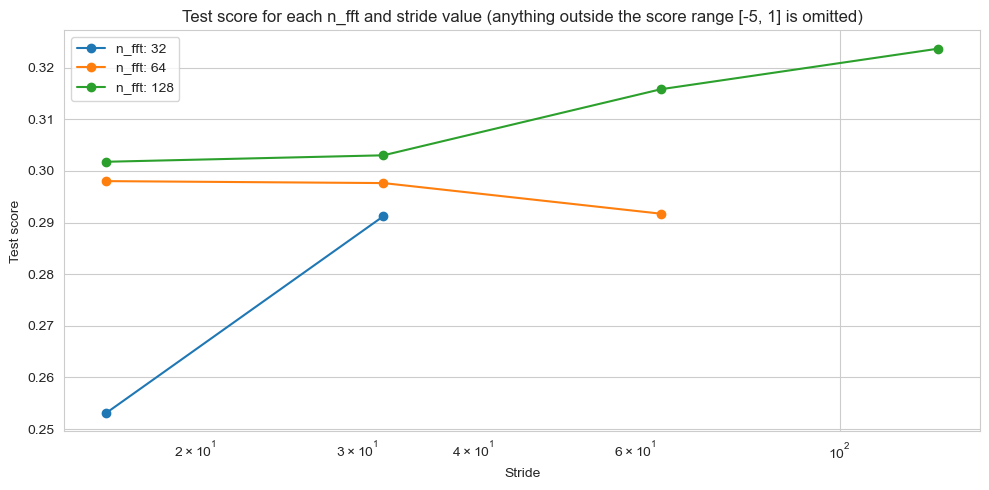

In [39]:
hierarchical_optimal_results_list_reshaped = reshape_nfft_scores(hierarchical_optimal_scores)
best_nfft_hierarchical, best_stride_hierarchical = get_best_and_plot(hierarchical_optimal_results_list_reshaped)

In [20]:
# Now, we will try with the threeHierarchicalESN with the optimal hyperparameters found in the previous notebook along with the spectrogram_data preprocessing method

# The optimal hyperparameters were:
# Best Neurons 1: 350, Best Neurons 2: 33, Best Neurons 3: 117
# Best Density 1: 0.8098222387059135, Best Density 2: 0.750474862642194, Best Density 3: 0.7438124394609645
# Best Leakage Rate 1: 0.9721196221438391, Best Leakage Rate 2: 0.5610244981317168, Best Leakage Rate 3: 0.6674647243532564
# Best Spectral Radius 1: 0.9048794207552125, Best Spectral Radius 2: 0.0532568977054132, Best Spectral Radius 3: 0.13303480091978592
# Best Gamma 1: 0.8008014185674769, Best Gamma 2: 0.1906404433300536, Best Gamma 3: 0.4754788170338825
# Best Weight Distribution 1: uniform, Best Weight Distribution 2: uniform, Best Weight Distribution 3: 0/1
# Best Sparsity 1: 0.302371243155928, Best Sparsity 2: 0.23013225478870247, Best Sparsity 3: 0.8292750282111857

threeh_n_neurons_1 = 350
threeh_density_1 = 0.8098222387059135
threeh_leakage_1 = 0.9721196221438391
threeh_spectral_radius_1 = 0.9048794207552125
threeh_gamma_1 = 0.8008014185674769
threeh_sparsity_1 = 0.302371243155928
threeh_input_weight_type_1 = 'uniform'

threeh_n_neurons_2 = 33
threeh_density_2 = 0.750474862642194
threeh_leakage_2 = 0.5610244981317168
threeh_spectral_radius_2 = 0.0532568977054132
threeh_gamma_2 = 0.1906404433300536
threeh_sparsity_2 = 0.23013225478870247
threeh_input_weight_type_2 = 'uniform'

threeh_n_neurons_3 = 117
threeh_density_3 = 0.7438124394609645
threeh_leakage_3 = 0.6674647243532564
threeh_spectral_radius_3 = 0.13303480091978592
threeh_gamma_3 = 0.4754788170338825
threeh_sparsity_3 = 0.8292750282111857
threeh_input_weight_type_3 = 'uniform'

In [21]:
run_three_hierarchical_optimal = True

In [22]:

if run_three_hierarchical_optimal:
    n_ffts = [32, 64, 128]
    strides = [16, 32, 64, 128]

    three_hierarchical_optimal_scores = []

    for n_fft in n_ffts:
        for stride in strides:
            if stride > n_fft:
                continue

            x_train_spec, y_train_spec = data_preprocessor.spectrogram_data(X_train, y_train,
                                                                            n_fft=n_fft, stride=stride,
                                                                            encode_labels=True,
                                                                            label_encoder=data_preparation.get_encoder())
            x_val_spec, y_val_spec = data_preprocessor.spectrogram_data(X_val, y_val, n_fft=n_fft,
                                                                        stride=stride,
                                                                        encode_labels=True,
                                                                        label_encoder=data_preparation.get_encoder())
            x_test_spec, y_test_spec = data_preprocessor.spectrogram_data(X_test, y_test, n_fft=n_fft,
                                                                          stride=stride,
                                                                          encode_labels=True,
                                                                          label_encoder=data_preparation.get_encoder())

            # Generate input weights has parameters n_neurons, n_features, density, input_weight_type
            input_weights_1 = generate_input_weights(threeh_n_neurons_1, x_train_spec.shape[1], threeh_density_1,
                                                     threeh_input_weight_type_1, seed=42)
            input_weights_2 = generate_input_weights(threeh_n_neurons_2, x_train_spec.shape[1], threeh_density_2,
                                                     threeh_input_weight_type_2, seed=42)
            input_weights_3 = generate_input_weights(threeh_n_neurons_3, x_train_spec.shape[1], threeh_density_3,
                                                     threeh_input_weight_type_3, seed=42)

            three_hierarchical_esn = ThreeHierarchyESN(n_neurons_1=threeh_n_neurons_1, n_neurons_2=threeh_n_neurons_2,
                                                       n_neurons_3=threeh_n_neurons_3,
                                                       leakage_rate_1=threeh_leakage_1, leakage_rate_2=threeh_leakage_2,
                                                       leakage_rate_3=threeh_leakage_3,
                                                       spectral_radius_1=threeh_spectral_radius_1,
                                                       spectral_radius_2=threeh_spectral_radius_2,
                                                       spectral_radius_3=threeh_spectral_radius_3,
                                                       gamma_1=threeh_gamma_1, gamma_2=threeh_gamma_2,
                                                       gamma_3=threeh_gamma_3,
                                                       sparsity_1=threeh_sparsity_1, sparsity_2=threeh_sparsity_2,
                                                       sparsity_3=threeh_sparsity_3,
                                                       W_in_1=input_weights_1, W_in_2=input_weights_2,
                                                       W_in_3=input_weights_3,
                                                       class_weights=class_weights, seed=42)

            three_hierarchical_esn.fit(x_train_spec, y_train_spec, x_val=x_val_spec, y_val=y_val_spec)

            y_pred = three_hierarchical_esn.forward(x_test_spec)

            # Before we can score the model, we need to decode the one-hot encoded labels
            # As we are using the spectrogram_data method, we need to convert the time frames back to samples
            y_pred_samples = data_preprocessor.spectrogram_predictions_to_samples(y_pred, y_test_encoded.shape[0],
                                                                                  n_fft, stride)

            y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred_samples)
            y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_encoded)

            # Calculate the NMRSE score
            nrmse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (
                    y_test_decoded.max() - y_test_decoded.min())

            three_hierarchical_optimal_scores.append({'n_fft': n_fft, 'stride': stride, 'nmrse': nrmse})

            print(f"n_fft: {n_fft}, stride: {stride}, NMRSE: {nrmse}")

else:
    three_hierarchical_optimal_scores = []

Spectrogram data shape: (84853, 102), (84853, 7)
Spectrogram data shape: (21213, 102), (21213, 7)
Spectrogram data shape: (35160, 102), (35160, 7)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 0.6674647243532564, spectral_radius_3: 0.13303480091978592, gamma_3: 0.4754788170338825, n_neurons_3: 117
Step: 0/84853
Step: 10000/84853
Step: 20000/84853
Step: 30000/84853
Step: 40000/84853
Step: 50000/84853
Step: 60000/84853
Step: 70000/84853
Step: 4853/84853
Shape of previous_states: (84853, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, fitting readout layer with validation data...
Step: 0/21213
Step: 10000/21213
Step: 1213/21213
Shape of previous_states: (21213, 500)
Alpha: 1e-05, Score: 

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.26872e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.2782559402207126, Score: 0.26649395133629344


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.02197e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.27915924207069526
Alpha: 16.681005372000556, Score: 0.2911048820319944
Alpha: 129.15496650148827, Score: 0.3075651037829155
Alpha: 1000.0, Score: 0.30987076961868176
Best alpha: 1000.0
Readout layer fitted.
Step: 0/35160
Step: 10000/35160
Step: 20000/35160
Step: 5160/35160
Shape of previous_states: (35160, 500)
Cumulative samples shape: (562547, 7)
n_fft: 32, stride: 16, NMRSE: 0.2545069717583786
Spectrogram data shape: (42427, 102), (42427, 7)
Spectrogram data shape: (10607, 102), (10607, 7)
Spectrogram data shape: (17580, 102), (17580, 7)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 0.6674647243532564, spectral_radius_3: 0.13303480091978592, gamma_3: 0.4754788170338825, n_neurons_

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.53477e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.05393e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.2782559402207126, Score: 0.2332057802987665
Alpha: 2.154434690031882, Score: 0.2557463221866804
Alpha: 16.681005372000556, Score: 0.2757838494815821
Alpha: 129.15496650148827, Score: 0.29446210186704336
Alpha: 1000.0, Score: 0.290484188256131
Best alpha: 129.15496650148827
Readout layer fitted.
Step: 0/17580
Step: 7580/17580
Shape of previous_states: (17580, 500)
Cumulative samples shape: (562547, 7)
n_fft: 32, stride: 32, NMRSE: 0.2726410886145234
Spectrogram data shape: (84853, 198), (84853, 7)
Spectrogram data shape: (21213, 198), (21213, 7)
Spectrogram data shape: (35160, 198), (35160, 7)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 0.6674647243532564, spectral_radius_3: 0.13303480091978592, gamma_3: 0.4

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.80702e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.2782559402207126, Score: 0.25851041626475


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.84221e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.26341211420338445
Alpha: 16.681005372000556, Score: 0.2700587990103359
Alpha: 129.15496650148827, Score: 0.2769678326844876
Alpha: 1000.0, Score: 0.2781635538435649
Best alpha: 1000.0
Readout layer fitted.
Step: 0/35160
Step: 10000/35160
Step: 20000/35160
Step: 5160/35160
Shape of previous_states: (35160, 500)
Cumulative samples shape: (562547, 7)
n_fft: 64, stride: 16, NMRSE: 0.2657438019225852
Spectrogram data shape: (42427, 198), (42427, 7)
Spectrogram data shape: (10607, 198), (10607, 7)
Spectrogram data shape: (17580, 198), (17580, 7)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 0.6674647243532564, spectral_radius_3: 0.13303480091978592, gamma_3: 0.4754788170338825, n_neurons_3

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.65921e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.29376e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.2782559402207126, Score: 0.236518592700287
Alpha: 2.154434690031882, Score: 0.24361012032528406
Alpha: 16.681005372000556, Score: 0.2550504560826788
Alpha: 129.15496650148827, Score: 0.26510781885630175
Alpha: 1000.0, Score: 0.26229014639562837
Best alpha: 129.15496650148827
Readout layer fitted.
Step: 0/17580
Step: 7580/17580
Shape of previous_states: (17580, 500)
Cumulative samples shape: (562547, 7)
n_fft: 64, stride: 32, NMRSE: 0.27644257811793754
Spectrogram data shape: (21214, 198), (21214, 7)
Spectrogram data shape: (5304, 198), (5304, 7)
Spectrogram data shape: (8790, 198), (8790, 7)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 0.6674647243532564, spectral_radius_3: 0.13303480091978592, gamma_3: 0.47

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.43868e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.53034e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 16.681005372000556, Score: 0.2438387375476321
Alpha: 129.15496650148827, Score: 0.25108561080142505
Alpha: 1000.0, Score: 0.23770259527348417
Best alpha: 129.15496650148827
Readout layer fitted.
Step: 8790/8790
Shape of previous_states: (8790, 500)
Cumulative samples shape: (562547, 7)
n_fft: 64, stride: 64, NMRSE: 0.29611911912856154
Spectrogram data shape: (84853, 390), (84853, 7)
Spectrogram data shape: (21213, 390), (21213, 7)
Spectrogram data shape: (35160, 390), (35160, 7)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 0.6674647243532564, spectral_radius_3: 0.13303480091978592, gamma_3: 0.4754788170338825, n_neurons_3: 117
Step: 0/84853
Step: 10000/84853
Step: 20000/84853
Step: 30000/84853
Step: 40000/8485

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.33529e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.2782559402207126, Score: 0.21050264124370113


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.04938e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.21434184526777722
Alpha: 16.681005372000556, Score: 0.2188852686650443
Alpha: 129.15496650148827, Score: 0.22572487049056456
Alpha: 1000.0, Score: 0.2329435176240407
Best alpha: 1000.0
Readout layer fitted.
Step: 0/35160
Step: 10000/35160
Step: 20000/35160
Step: 5160/35160
Shape of previous_states: (35160, 500)
Cumulative samples shape: (562547, 7)
n_fft: 128, stride: 16, NMRSE: 0.30035584265645404
Spectrogram data shape: (42427, 390), (42427, 7)
Spectrogram data shape: (10607, 390), (10607, 7)
Spectrogram data shape: (17580, 390), (17580, 7)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 0.6674647243532564, spectral_radius_3: 0.13303480091978592, gamma_3: 0.4754788170338825, n_neuron

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.56429e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.13942e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.2782559402207126, Score: 0.18509613231104405
Alpha: 2.154434690031882, Score: 0.19413047249577486
Alpha: 16.681005372000556, Score: 0.20335896128407333
Alpha: 129.15496650148827, Score: 0.2169500559315181
Alpha: 1000.0, Score: 0.22136384285334693
Best alpha: 1000.0
Readout layer fitted.
Step: 0/17580
Step: 7580/17580
Shape of previous_states: (17580, 500)
Cumulative samples shape: (562547, 7)
n_fft: 128, stride: 32, NMRSE: 0.3129769813579676
Spectrogram data shape: (21214, 390), (21214, 7)
Spectrogram data shape: (5304, 390), (5304, 7)
Spectrogram data shape: (8790, 390), (8790, 7)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 0.6674647243532564, spectral_radius_3: 0.13303480091978592, gamma_3: 0.475478817033

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.43268e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.95737e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.03907e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.17580975900245943
Alpha: 16.681005372000556, Score: 0.19261816692180567
Alpha: 129.15496650148827, Score: 0.2074285230607476
Alpha: 1000.0, Score: 0.20098265856349742
Best alpha: 129.15496650148827
Readout layer fitted.
Step: 8790/8790
Shape of previous_states: (8790, 500)
Cumulative samples shape: (562547, 7)
n_fft: 128, stride: 64, NMRSE: 0.31921100773123817
Spectrogram data shape: (10607, 390), (10607, 7)
Spectrogram data shape: (2652, 390), (2652, 7)
Spectrogram data shape: (4395, 390), (4395, 7)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 0.6674647243532564, spectral_radius_3: 0.13303480091978592, gamma_3: 0.4754788170338825, n_neurons_3: 117
Step: 0/10607
Step: 607/10607
Shap

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.20516e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.26955e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.03995e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: 0.05026937344889033
Alpha: 0.03593813663804626, Score: 0.11145147859048514
Alpha: 0.2782559402207126, Score: 0.1439910264585113
Alpha: 2.154434690031882, Score: 0.17720467899653183
Alpha: 16.681005372000556, Score: 0.18691464764936017
Alpha: 129.15496650148827, Score: 0.18467307219071047
Alpha: 1000.0, Score: 0.16328699052411969
Best alpha: 16.681005372000556
Readout layer fitted.
Step: 4395/4395
Shape of previous_states: (4395, 500)
Cumulative samples shape: (562547, 7)
n_fft: 128, stride: 128, NMRSE: 0.3558309570434513


In [23]:
print(three_hierarchical_optimal_scores)

[{'n_fft': 32, 'stride': 16, 'nmrse': 0.2545069717583786}, {'n_fft': 32, 'stride': 32, 'nmrse': 0.2726410886145234}, {'n_fft': 64, 'stride': 16, 'nmrse': 0.2657438019225852}, {'n_fft': 64, 'stride': 32, 'nmrse': 0.27644257811793754}, {'n_fft': 64, 'stride': 64, 'nmrse': 0.29611911912856154}, {'n_fft': 128, 'stride': 16, 'nmrse': 0.30035584265645404}, {'n_fft': 128, 'stride': 32, 'nmrse': 0.3129769813579676}, {'n_fft': 128, 'stride': 64, 'nmrse': 0.31921100773123817}, {'n_fft': 128, 'stride': 128, 'nmrse': 0.3558309570434513}]


Best n_fft: 32, Best stride: 32


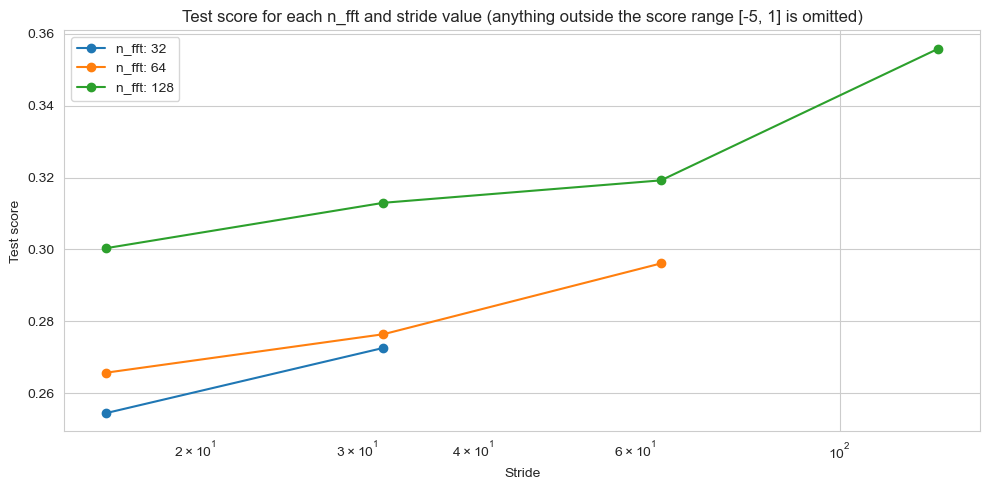

In [40]:
three_hierarchical_optimal_results_list_reshaped = reshape_nfft_scores(three_hierarchical_optimal_scores)
best_nfft_three_hierarchical, best_stride_three_hierarchical = get_best_and_plot(
    three_hierarchical_optimal_results_list_reshaped)

In [25]:
# Now we can try the best of each model and evaluate them on the test set
# We will use the best n_fft and stride values found for each model
basicESN_pickle = 'basicESN_har70_spectrogram.pkl'

# First, the basicESN
x_train_spec, y_train_spec = data_preprocessor.spectrogram_data(X_train, y_train, n_fft=best_nfft_basic,
                                                                stride=best_stride_basic,
                                                                encode_labels=True,
                                                                label_encoder=data_preparation.get_encoder())
x_val_spec, y_val_spec = data_preprocessor.spectrogram_data(X_val, y_val, n_fft=best_nfft_basic,
                                                            stride=best_stride_basic,
                                                            encode_labels=True,
                                                            label_encoder=data_preparation.get_encoder())
x_test_spec, y_test_spec = data_preprocessor.spectrogram_data(X_test, y_test, n_fft=best_nfft_basic,
                                                              stride=best_stride_basic,
                                                              encode_labels=True,
                                                              label_encoder=data_preparation.get_encoder())

if run_basic_optimal or not os.path.exists(basicESN_pickle):

    input_weights = generate_input_weights(basic_n_neurons, x_train_spec.shape[1], basic_density,
                                           basic_input_weight_type, seed=42)

    basic_esn = BasicESN(n_neurons=basic_n_neurons, leakage_rate=basic_leakage, spectral_radius=basic_spectral_radius,
                         gamma=basic_gamma,
                         sparsity=basic_sparsity, W_in=input_weights, class_weights=class_weights, seed=42)

    basic_esn.fit(x_train_spec, y_train_spec, x_val=x_val_spec, y_val=y_val_spec)

    with open(basicESN_pickle, 'wb') as f:
        pickle.dump(basic_esn, f)

else:
    with open(basicESN_pickle, 'rb') as f:
        basic_esn = pickle.load(f)

y_pred = basic_esn.forward(x_test_spec)

# Before we can score the model, we need to decode the one-hot encoded labels
# As we are using the spectrogram_data method, we need to convert the time frames back to samples
y_pred_samples = data_preprocessor.spectrogram_predictions_to_samples(y_pred, y_test_encoded.shape[0], best_nfft_basic,
                                                                      best_stride_basic)

y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred_samples)
y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_encoded)

# Calculate the NMRSE score
nrmse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (y_test_decoded.max() - y_test_decoded.min())

print(f"BasicESN NMRSE: {nrmse}")

Spectrogram data shape: (84853, 102), (84853, 7)
Spectrogram data shape: (21213, 102), (21213, 7)
Spectrogram data shape: (35160, 102), (35160, 7)
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.8, spectral_radius: 0.999, gamma: 0.999, n_neurons: 500, sparsity: 0.8


100%|██████████| 84853/84853 [00:24<00:00, 3491.29it/s]


Shape of previous_states: (84853, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, scoring readout layer based on validation data...


100%|██████████| 21213/21213 [00:06<00:00, 3437.91it/s]


Shape of previous_states: (21213, 500)
Alpha: 1e-05, Score: 0.29211041179134056
Alpha: 5.994842503189409e-05, Score: 0.30356072333379724


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.01321e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.00035938136638046257, Score: 0.30397176105650175


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.05598e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.0021544346900318843, Score: 0.3041269188382433


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.52783e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.01291549665014884, Score: 0.30453971847209677


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.26193e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.0774263682681127, Score: 0.3052610598745736


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.12645e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.4641588833612782, Score: 0.30667371566463186


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.61507e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.782559402207126, Score: 0.30913267980945197
Alpha: 16.68100537200059, Score: 0.3131172323766384
Alpha: 100.0, Score: 0.31809304511054975
Best alpha: 100.0
Readout layer fitted.


100%|██████████| 35160/35160 [00:09<00:00, 3530.84it/s]


Shape of previous_states: (35160, 500)
Cumulative samples shape: (562547, 7)
BasicESN NMRSE: 0.2280657272340775


In [26]:
# Create a classification report
from sklearn.metrics import classification_report

print(classification_report(y_test_decoded, y_pred_decoded))

              precision    recall  f1-score   support

           1       0.97      0.80      0.88    346581
           3       0.10      0.45      0.16     19640
           4       0.19      0.44      0.27      2708
           5       0.01      0.84      0.02       370
           6       0.84      0.59      0.69    141796
           7       0.97      0.92      0.95     43204
           8       0.98      1.00      0.99      8248

    accuracy                           0.74    562547
   macro avg       0.58      0.72      0.56    562547
weighted avg       0.90      0.74      0.81    562547



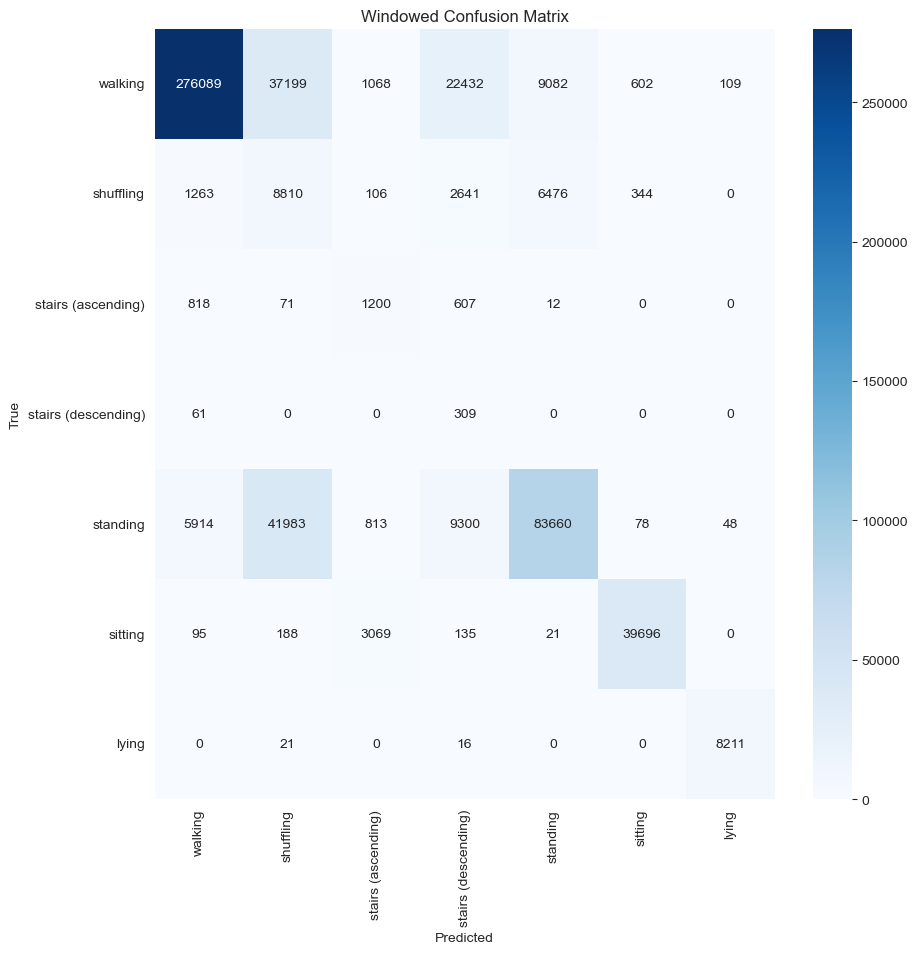

In [27]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = ['walking', 'shuffling', 'stairs (ascending)', 'stairs (descending)', 'standing', 'sitting', 'lying']

conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Windowed Confusion Matrix')
plt.show()

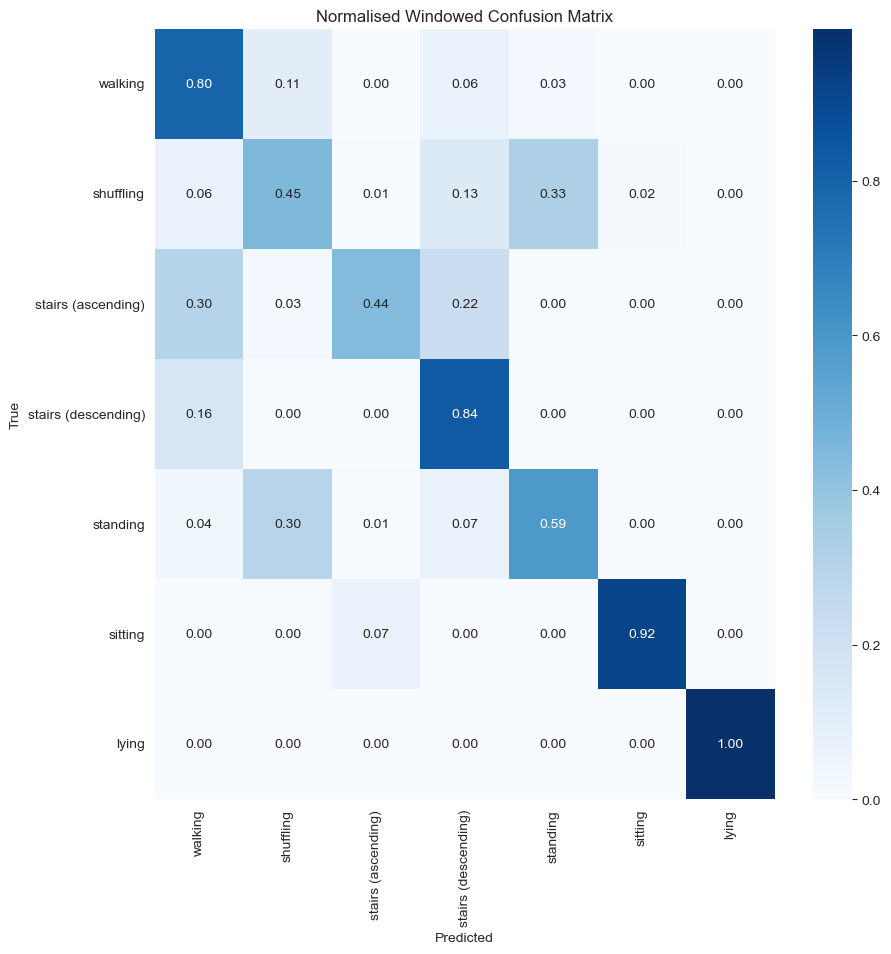

In [28]:
# Now a normalised confusion matrix
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Windowed Confusion Matrix')
plt.show()

In [29]:
# Next, the HierarchicalESN
hierarchicalESN_pickle = 'hierarchyESN_har70_spectrogram.pkl'

x_train_spec, y_train_spec = data_preprocessor.spectrogram_data(X_train, y_train, n_fft=best_nfft_hierarchical,
                                                                stride=best_stride_hierarchical,
                                                                encode_labels=True,
                                                                label_encoder=data_preparation.get_encoder())
x_val_spec, y_val_spec = data_preprocessor.spectrogram_data(X_val, y_val, n_fft=best_nfft_hierarchical,
                                                            stride=best_stride_hierarchical,
                                                            encode_labels=True,
                                                            label_encoder=data_preparation.get_encoder())

x_test_spec, y_test_spec = data_preprocessor.spectrogram_data(X_test, y_test, n_fft=best_nfft_hierarchical,
                                                              stride=best_stride_hierarchical,
                                                              encode_labels=True,
                                                              label_encoder=data_preparation.get_encoder())

if run_hierarchical_optimal or not os.path.exists(hierarchicalESN_pickle):

    input_weights_1 = generate_input_weights(hierarchy_n_neurons_1, x_train_spec.shape[1], hierarchy_density_1,
                                             hierarchy_input_weight_type_1, seed=42)
    input_weights_2 = generate_input_weights(hierarchy_n_neurons_2, x_train_spec.shape[1], hierarchy_density_2,
                                             hierarchy_input_weight_type_2, seed=42)

    hierarchical_esn = HierarchyESN(n_neurons_1=hierarchy_n_neurons_1, n_neurons_2=hierarchy_n_neurons_2,
                                    leakage_rate_1=hierarchy_leakage_1,
                                    leakage_rate_2=hierarchy_leakage_2,
                                    spectral_radius_1=hierarchy_spectral_radius_1,
                                    spectral_radius_2=hierarchy_spectral_radius_2,
                                    gamma_1=hierarchy_gamma_1, gamma_2=hierarchy_gamma_2,
                                    sparsity_1=hierarchy_sparsity_1, sparsity_2=hierarchy_sparsity_2,
                                    W_in_1=input_weights_1,
                                    W_in_2=input_weights_2,
                                    class_weights=class_weights, seed=42)

    hierarchical_esn.fit(x_train_spec, y_train_spec, x_val=x_val_spec, y_val=y_val_spec)

    with open(hierarchicalESN_pickle, 'wb') as f:
        pickle.dump(hierarchical_esn, f)

else:
    with open(hierarchicalESN_pickle, 'rb') as f:
        hierarchical_esn = pickle.load(f)

y_pred = hierarchical_esn.forward(x_test_spec)

# Before we can score the model, we need to decode the one-hot encoded labels
# As we are using the spectrogram_data method, we need to convert the time frames back to samples
y_pred_samples = data_preprocessor.spectrogram_predictions_to_samples(y_pred, y_test_encoded.shape[0],
                                                                      best_nfft_hierarchical, best_stride_hierarchical)

y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred_samples)
y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_encoded)

# Calculate the NMRSE score
nrmse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (y_test_decoded.max() - y_test_decoded.min())

print(f"HierarchicalESN NMRSE: {nrmse}")

Spectrogram data shape: (84853, 102), (84853, 7)
Spectrogram data shape: (21213, 102), (21213, 7)
Spectrogram data shape: (35160, 102), (35160, 7)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9318915931720418, spectral_radius_1: 0.9819903553570943, gamma_1: 0.9634809164294149, n_neurons_1: 400, leakage_rate_2: 0.35101073644620073, spectral_radius_2: 0.1404437385565157, gamma_2: 0.7797466776214464, n_neurons_2: 100


100%|██████████| 84853/84853 [00:52<00:00, 1619.67it/s]


Shape of previous_states: (84853, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, fitting readout layer with validation data...


100%|██████████| 21213/21213 [00:13<00:00, 1618.63it/s]


Shape of previous_states: (21213, 500)
Alpha: 1e-05, Score: 0.2698647472586209
Alpha: 7.742636826811278e-05, Score: 0.2803303818445814
Alpha: 0.0005994842503189409, Score: 0.2809652398056516
Alpha: 0.004641588833612777, Score: 0.2818219240188292


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.9713e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.03593813663804626, Score: 0.2821846085337171


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.45678e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.2782559402207126, Score: 0.2862487785121873


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.78421e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.29134656781609436
Alpha: 16.681005372000556, Score: 0.2992477072878458
Alpha: 129.15496650148827, Score: 0.3108933019758712
Alpha: 1000.0, Score: 0.3101160843211459
Best alpha: 129.15496650148827
Readout layer fitted.


100%|██████████| 35160/35160 [00:21<00:00, 1611.41it/s]


Shape of previous_states: (35160, 500)
Cumulative samples shape: (562547, 7)
HierarchicalESN NMRSE: 0.2530920784609683


In [30]:
# Create a classification report
print(classification_report(y_test_decoded, y_pred_decoded))

              precision    recall  f1-score   support

           1       0.95      0.77      0.85    346581
           3       0.10      0.56      0.17     19640
           4       0.12      0.39      0.19      2708
           5       0.01      0.87      0.01       370
           6       0.86      0.37      0.52    141796
           7       0.99      0.92      0.95     43204
           8       1.00      1.00      1.00      8248

    accuracy                           0.68    562547
   macro avg       0.58      0.70      0.53    562547
weighted avg       0.90      0.68      0.75    562547



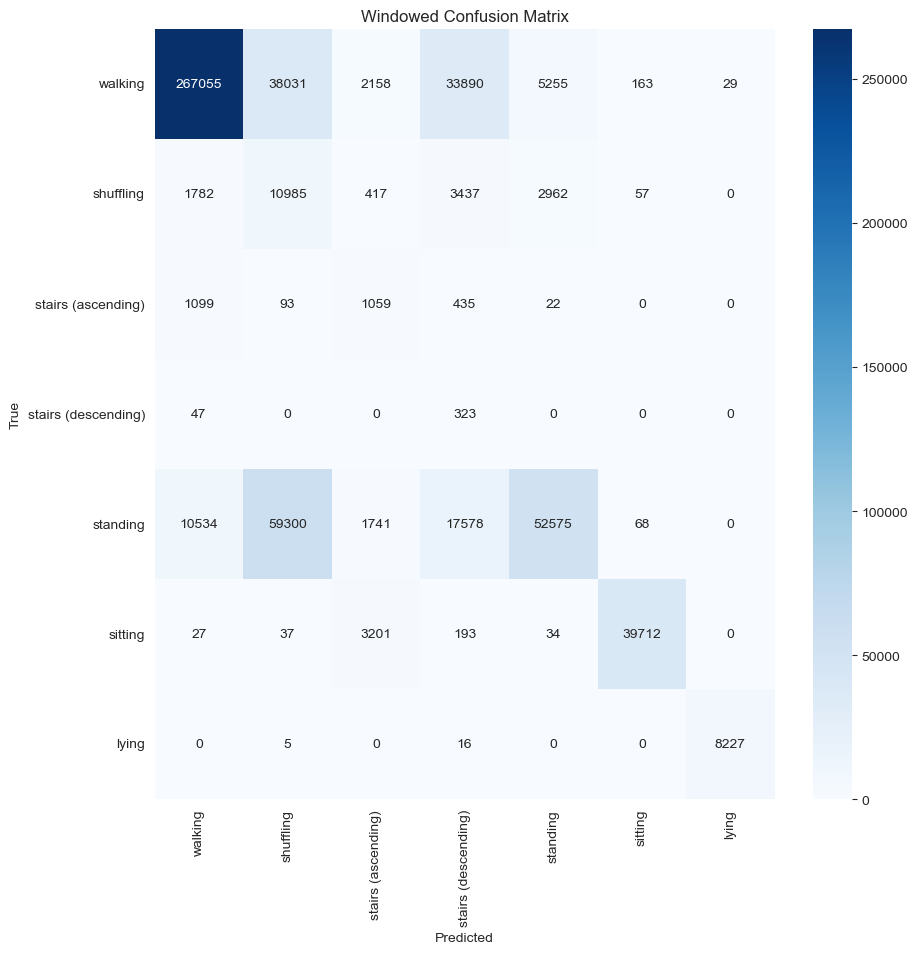

In [31]:
# Print the confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Windowed Confusion Matrix')
plt.show()

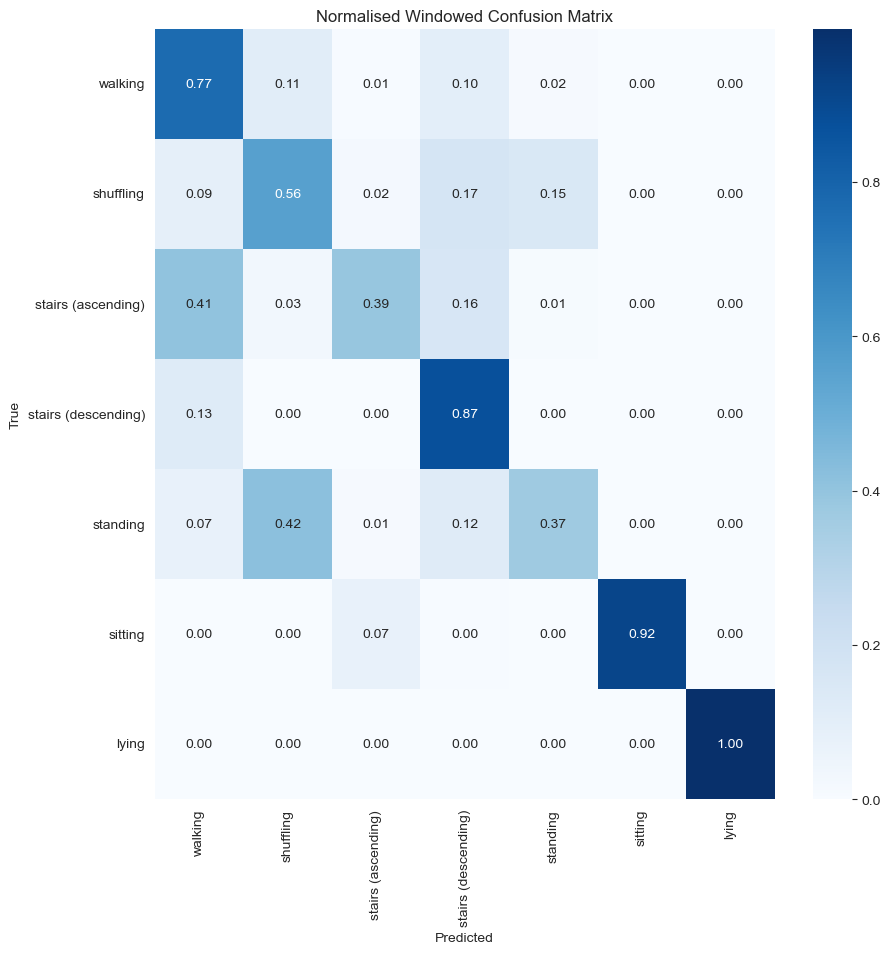

In [32]:
# Now a normalised confusion matrix
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Windowed Confusion Matrix')
plt.show()

In [33]:
# Finally, the ThreeHierarchyESN
threeHierarchyESN_pickle = 'threeHierarchyESN_har70_spectrogram.pkl'

x_train_spec, y_train_spec = data_preprocessor.spectrogram_data(X_train, y_train, n_fft=best_nfft_three_hierarchical,
                                                                stride=best_stride_three_hierarchical,
                                                                encode_labels=True,
                                                                label_encoder=data_preparation.get_encoder())

x_val_spec, y_val_spec = data_preprocessor.spectrogram_data(X_val, y_val, n_fft=best_nfft_three_hierarchical,
                                                            stride=best_stride_three_hierarchical,
                                                            encode_labels=True,
                                                            label_encoder=data_preparation.get_encoder())

x_test_spec, y_test_spec = data_preprocessor.spectrogram_data(X_test, y_test, n_fft=best_nfft_three_hierarchical,
                                                              stride=best_stride_three_hierarchical,
                                                              encode_labels=True,
                                                              label_encoder=data_preparation.get_encoder())

if run_three_hierarchical_optimal or not os.path.exists(threeHierarchyESN_pickle):

    input_weights_1 = generate_input_weights(threeh_n_neurons_1, x_train_spec.shape[1], threeh_density_1,
                                             threeh_input_weight_type_1, seed=42)
    input_weights_2 = generate_input_weights(threeh_n_neurons_2, x_train_spec.shape[1], threeh_density_2,
                                             threeh_input_weight_type_2, seed=42)
    input_weights_3 = generate_input_weights(threeh_n_neurons_3, x_train_spec.shape[1], threeh_density_3,
                                             threeh_input_weight_type_3, seed=42)

    three_hierarchical_esn = ThreeHierarchyESN(n_neurons_1=threeh_n_neurons_1, n_neurons_2=threeh_n_neurons_2,
                                               n_neurons_3=threeh_n_neurons_3,
                                               leakage_rate_1=threeh_leakage_1, leakage_rate_2=threeh_leakage_2,
                                               leakage_rate_3=threeh_leakage_3,
                                               spectral_radius_1=threeh_spectral_radius_1,
                                               spectral_radius_2=threeh_spectral_radius_2,
                                               spectral_radius_3=threeh_spectral_radius_3,
                                               gamma_1=threeh_gamma_1, gamma_2=threeh_gamma_2, gamma_3=threeh_gamma_3,
                                               sparsity_1=threeh_sparsity_1, sparsity_2=threeh_sparsity_2,
                                               sparsity_3=threeh_sparsity_3,
                                               W_in_1=input_weights_1, W_in_2=input_weights_2, W_in_3=input_weights_3,
                                               class_weights=class_weights, seed=42)

    three_hierarchical_esn.fit(x_train_spec, y_train_spec, x_val=x_val_spec, y_val=y_val_spec)

    with open(threeHierarchyESN_pickle, 'wb') as f:
        pickle.dump(three_hierarchical_esn, f)

else:
    with open(threeHierarchyESN_pickle, 'rb') as f:
        three_hierarchical_esn = pickle.load(f)

y_pred = three_hierarchical_esn.forward(x_test_spec)

# Before we can score the model, we need to decode the one-hot encoded labels
# As we are using the spectrogram_data method, we need to convert the time frames back to samples
y_pred_samples = data_preprocessor.spectrogram_predictions_to_samples(y_pred, y_test_encoded.shape[0],
                                                                      best_nfft_three_hierarchical,
                                                                      best_stride_three_hierarchical)

y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred_samples)
y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_encoded)

# Calculate the NMRSE score
nrmse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (y_test_decoded.max() - y_test_decoded.min())

print(f"ThreeHierarchyESN NMRSE: {nrmse}")

Spectrogram data shape: (84853, 102), (84853, 7)
Spectrogram data shape: (21213, 102), (21213, 7)
Spectrogram data shape: (35160, 102), (35160, 7)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 0.6674647243532564, spectral_radius_3: 0.13303480091978592, gamma_3: 0.4754788170338825, n_neurons_3: 117
Step: 0/84853
Step: 10000/84853
Step: 20000/84853
Step: 30000/84853
Step: 40000/84853
Step: 50000/84853
Step: 60000/84853
Step: 70000/84853
Step: 4853/84853
Shape of previous_states: (84853, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, fitting readout layer with validation data...
Step: 0/21213
Step: 10000/21213
Step: 1213/21213
Shape of previous_states: (21213, 500)
Alpha: 1e-05, Score: 

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.27814e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.2782559402207126, Score: 0.26657381727826746


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.01994e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.2791747437382481
Alpha: 16.681005372000556, Score: 0.2911068886149836
Alpha: 129.15496650148827, Score: 0.30756611443384446
Alpha: 1000.0, Score: 0.30987083312017255
Best alpha: 1000.0
Readout layer fitted.
Step: 0/35160
Step: 10000/35160
Step: 20000/35160
Step: 5160/35160
Shape of previous_states: (35160, 500)
Cumulative samples shape: (562547, 7)
ThreeHierarchyESN NMRSE: 0.2545069717583786


In [34]:
# Create a classification report
print(classification_report(y_test_decoded, y_pred_decoded))

              precision    recall  f1-score   support

           1       0.95      0.75      0.84    346581
           3       0.09      0.60      0.16     19640
           4       0.16      0.37      0.22      2708
           5       0.00      0.52      0.01       370
           6       0.87      0.40      0.55    141796
           7       0.99      0.92      0.95     43204
           8       0.99      1.00      0.99      8248

    accuracy                           0.67    562547
   macro avg       0.58      0.65      0.53    562547
weighted avg       0.90      0.67      0.75    562547



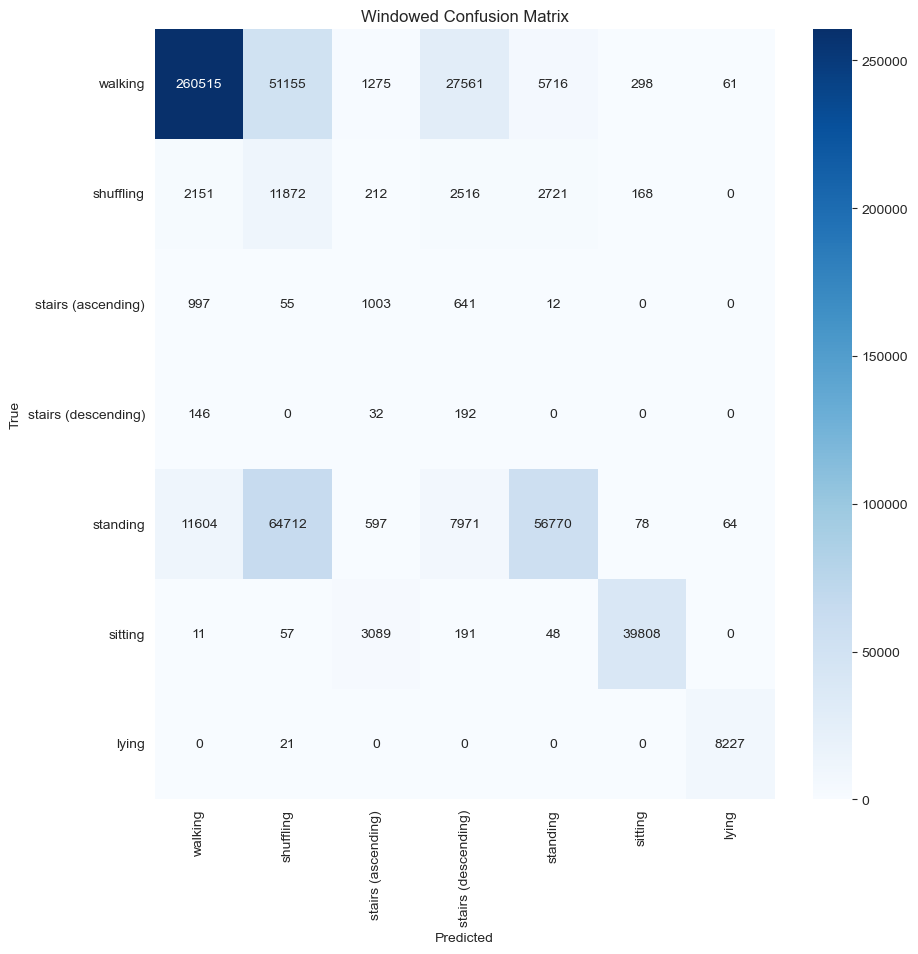

In [35]:
# Print the confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Windowed Confusion Matrix')
plt.show()

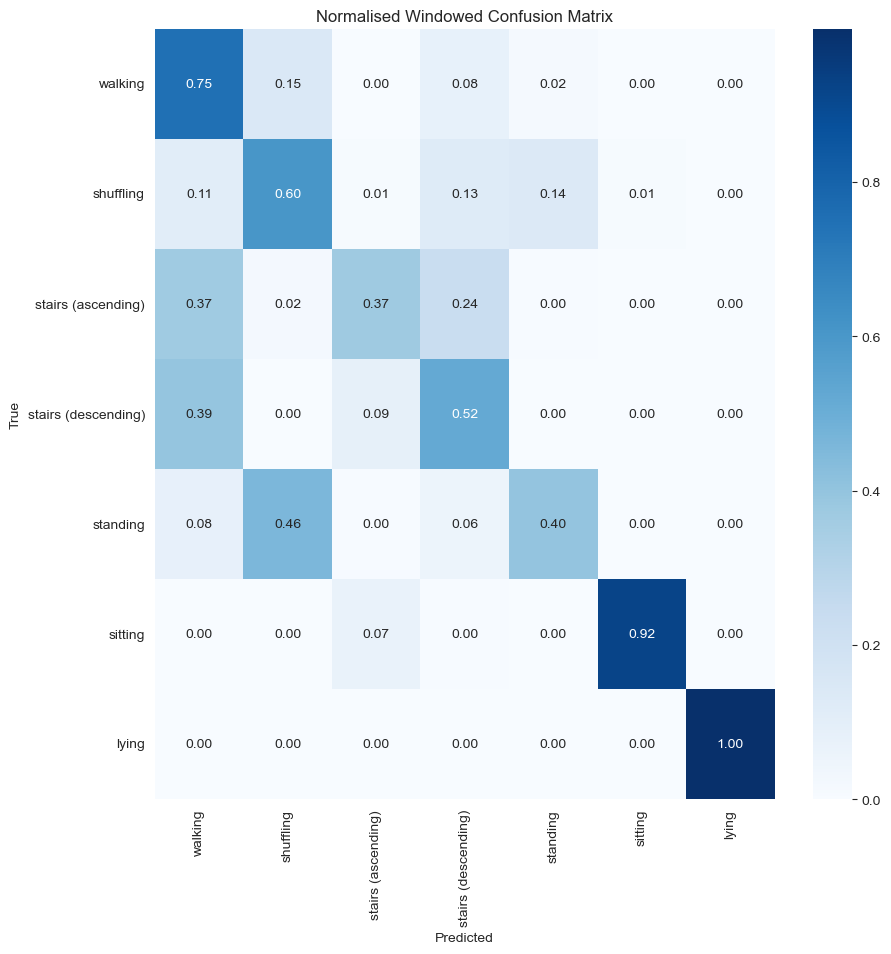

In [36]:
# Now a normalised confusion matrix
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Windowed Confusion Matrix')
plt.show()